# k-Armed Bandit

- The *value* is the *expected reward*

$$
\begin{align*}
q_\star(a) &\doteq \mathbb{E}[R_t|A_t=a]\ \forall{a}\in\{1,\ldots,k\} \\
                &= \sum_r{p(r|a)r}
\end{align*}
$$

- The goal is to *maximize* the *expected reward*

$$
\underset{a}{\mathrm{argmax}}\ q_\star(a)
$$

## Value of an Action

- $q_\star(a)$ is not known, so we *estimate* it

### Sample-Average Method

$$
\begin{align*}
Q_t(a) &\doteq \frac{\text{sum of rewards when $a$ taken prior to $t$}}{\text{# of times $a$ taken prior to $t$}} \\
            &= \frac{\sum^{t-1}_{i=1}{R_i}}{t-1}
\end{align*}
$$

### Incremental update

$$
\begin{align*}
Q_{n_1} &= \frac{1}{n}\sum^{n}_{i=1}{R_i} \\
        &= \frac{1}{n}(R_n + \sum^{n-1}_{i=1}{R_i}) \\
        &= \frac{1}{n}(R_n + (n - 1)\frac{1}{n-1}\sum^{n-1}_{i=1}{R_i}) \\
        &= \frac{1}{n}(R_n + nQ_n - Q_n) \\
        &= Q_n + \frac{1}{n}(R_n - Q_n)
\end{align*}
$$

### Incremental update rule

- This is an example of *Non-stationary bandit problem*

$$
\begin{gather*}
\mathit{NewEstimate} \leftarrow \mathit{OldEstimate} + \mathit{StepSize}(\mathit{Target} - \mathit{OldEstimate}) \\
Q_{n+1} = Q_n + \alpha_n(R_n - Q_n) \\
\alpha_n \to [0,1]
\end{gather*}
$$

### Decaying past rewards

- Inital action-value decreases exponentially with time
- The rewards further back in contribute exponentially less to the sum

$$
\begin{align*}
Q_{n+1} &= Q_n + \alpha_n(R_n - Q_n) \\
        &= \alpha R_n + (1-\alpha)\alpha R_{n-1} + (1-\alpha)^2 R_{n-2} + \cdots + (1-\alpha)^{n-1}\alpha R_1 + (1-\alpha)^nQ_1 \\
        &= (1-\alpha)^n\underbrace{Q_1}_{\text{initial action-value}} + \sum^{n}_{i=1}{\alpha(1-\alpha)^{n-i}R_i}
\end{align*}
$$

## Exploration and Exploitation

- *Exploration* - *improve* knowledge for *long-term* benefit
- *Exploitation* - *exploit* knowledge for *short-term* benefit

### Epsilon-Greedy Action Selection

$$
A_t \leftarrow
\begin{cases}
  \underset{a}{\mathrm{argmax}}\ Q_t(a) & \text{with probability}~1 - \epsilon\\
  a \sim \mathit{Uniform}(\{a_1 \ldots a_k\}) & \text{with probability}~\epsilon\\
\end{cases}
$$


Text(0, 0.5, 'Reward distribution')

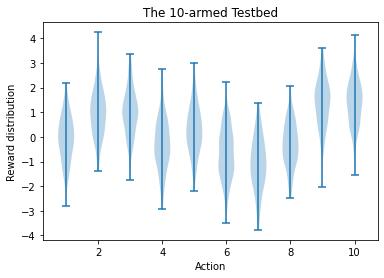

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.violinplot(dataset=np.random.randn(200, 10) + np.random.randn(10))
plt.title('The 10-armed Testbed')
plt.xlabel('Action')
plt.ylabel('Reward distribution')

In [2]:
from tqdm import trange

class Bandit:
    def __init__(self, k_arm=10, epsilon=0, initial=0, step_size=0.1, sample_averages=False, UCB_param=None,
                 gradient=False, gradient_baseline=False, true_reward=0):
        self.k = k_arm
        self.step_size = step_size
        self.sample_averages = sample_averages
        self.indices = np.arange(self.k)
        self.time = 0
        self.UCB_param = UCB_param
        self.gradient = gradient
        self.gradient_baseline = gradient_baseline
        self.average_reward = 0
        self.true_reward = true_reward
        self.epsilon = epsilon
        self.initial = initial

    def reset(self):
        # real reward for each action
        self.q_true = np.random.randn(self.k) + self.true_reward

        # estimation for each action
        self.q_estimation = np.zeros(self.k) + self.initial

        # # of chosen times for each action
        self.action_count = np.zeros(self.k)

        self.best_action = np.argmax(self.q_true)

        self.time = 0
    
    def act(self):
        """
        get an action for this bandit
        """
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.indices)
        
        if self.UCB_param is not None:
            UCB_estimation = self.q_estimation + self.UCB_param * np.sqrt(np.log(self.time + 1) / (self.action_count + 1e-5))
            q_best = np.max(UCB_estimation)
            return np.random.choice(np.where(UCB_estimation == q_best)[0])

        q_best = np.max(self.q_estimation)
        return np.random.choice(np.where(self.q_estimation == q_best)[0])
    
    def step(self, action):
        """
        take an action, update estimation for this action
        """
        # generate the reward under N(real reward, 1)
        reward = np.random.randn() + self.q_true[action]
        self.time += 1
        self.action_count[action] += 1
        self.average_reward += (reward - self.average_reward) / self.time

        if self.sample_averages:
            # update estimation using sample averages
            self.q_estimation[action] += (reward - self.q_estimation[action]) / self.action_count[action]
        elif self.gradient:
            one_hot = np.zeros(self.k)
            one_hot[action] = 1
            if self.gradient_baseline:
                baseline = self.average_reward
            else:
                baseline = 0
            self.q_estimation += self.step_size  * (rweard - baseline) * (one_hot - self.action_prob)
        else:
            # update estimation with constant step size
            self.q_estimation[action] += self.step_size * (reward - self.q_estimation[action])
        return reward

def simulate(runs, time, bandits):
    rewards = np.zeros((len(bandits), runs, time))
    best_action_counts = np.zeros(rewards.shape)
    for i, bandit in enumerate(bandits):
        for r in trange(runs):
            bandit.reset()
            for t in range(time):
                action = bandit.act()
                reward = bandit.step(action)
                rewards[i, r, t] = reward
                if action == bandit.best_action:
                    best_action_counts[i, r, t] = 1
    mean_best_action_counts = best_action_counts.mean(axis=1)
    mean_rewards = rewards.mean(axis=1)
    return mean_best_action_counts, mean_rewards

100%|██████████| 2000/2000 [01:05<00:00, 30.72it/s]


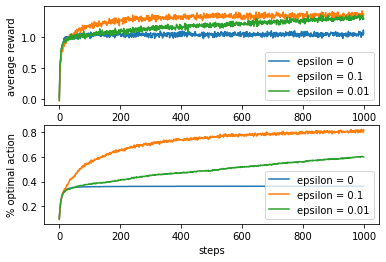

In [3]:
runs = 2000
time = 1000

epsilons = [0, 0.1, 0.01]
bandits = [Bandit(epsilon=eps, sample_averages=True) for eps in epsilons]
best_action_counts, rewards = simulate(runs, time, bandits)

plt.figure()
plt.subplot(2, 1, 1)
for eps, reward in zip(epsilons, rewards):
    plt.plot(reward, label=f'epsilon = {eps}')
plt.xlabel('steps')
plt.ylabel('average reward')
plt.legend()
plt.subplot(2, 1, 2)
for eps, counts in zip(epsilons, best_action_counts):
    plt.plot(counts, label=f'epsilon = {eps}')
plt.xlabel('steps')
plt.ylabel('% optimal action')
plt.legend()

## Optimistic Initial Value

- Optimistic initial values encourage *early exploration*
- Limitations
  - Optiministic initial values only *drive early exploration*
  - They are not well-suited for *non-stationary problems*
  - We may not know what the *optiministic initial value* should be

100%|██████████| 2000/2000 [00:50<00:00, 39.36it/s]


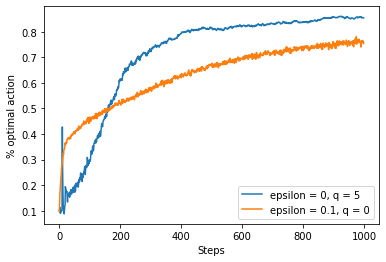

In [4]:
runs = 2000
time = 1000
bandits = []
bandits.append(Bandit(epsilon=0, initial=5, step_size=0.1))
bandits.append(Bandit(epsilon=0.1, initial=0, step_size=0.1))
best_action_counts, _ = simulate(runs, time, bandits)

plt.plot(best_action_counts[0], label='epsilon = 0, q = 5')
plt.plot(best_action_counts[1], label='epsilon = 0.1, q = 0')
plt.xlabel('Steps')
plt.ylabel('% optimal action')
plt.legend()

## Upper-Confidence Bound (UCB) Action Selection

- *Upper-Confidence Bound action-selection* uses *uncertainty* in the value estimates for balancing exploration and exploitation

$$
A_t \doteq \mathrm{argmax}[\underbrace{Q_t(a)}_{Exploit}+\underbrace{c\sqrt{\frac{\ln t}{N_t(a)}}}_{Explore}]
$$

100%|██████████| 2000/2000 [00:49<00:00, 40.01it/s]


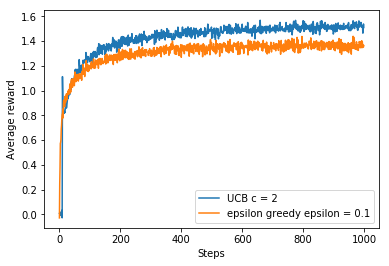

In [21]:
bandits = []
bandits.append(Bandit(epsilon=0, UCB_param=2, sample_averages=True))
bandits.append(Bandit(epsilon=0.1, sample_averages=True))
_, average_rewards = simulate(runs, time, bandits)

plt.plot(average_rewards[0], label='UCB c = 2')
plt.plot(average_rewards[1], label='epsilon greedy epsilon = 0.1')
plt.xlabel('Steps')
plt.ylabel('Average reward')
plt.legend()